In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch    
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

In [2]:
train_mean = [0.1158,0.1162,0.1204]
train_std = [0.2915,0.2927,0.3023]

# Transforms to be applied to data

train_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(train_mean),torch.Tensor(train_std))
])

valid_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(train_mean),torch.Tensor(train_std))
])

In [3]:
# TODO: Load the datasets with ImageFolder
train_dataset = datasets.ImageFolder('./Rice_Image_Dataset/Train/', transform=train_transforms)
train_set,valid_set = torch.utils.data.random_split(train_dataset,[len(train_dataset)-500,500])
valid_set.transforms = valid_transforms

# TODO: Using the image datasets and the trainforms, define the dataloaders
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=32)

In [4]:
model = models.vgg16(pretrained=True)

c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
# Freeze pretrained model parameters to avoid backpropogating through them
for parameter in model.parameters():
    parameter.requires_grad = False


from collections import OrderedDict

# Build custom classifier
classifier = nn.Sequential(OrderedDict([('fc1', nn.Linear(25088, 5000)),
                                        ('relu', nn.ReLU()),
                                        ('drop', nn.Dropout(p=0.5)),
                                        ('fc2', nn.Linear(5000, 102)),
                                        ('output', nn.LogSoftmax(dim=1))]))

model.classifier = classifier

In [6]:
# Function for the validation pass
def validation(model, validateloader, criterion):
    
    val_loss = 0
    accuracy = 0
    
    for images, labels in iter(validateloader):

        images, labels = images.to('cuda'), labels.to('cuda')

        output = model.forward(images)
        val_loss += criterion(output, labels).item()

        probabilities = torch.exp(output)
        
        equality = (labels.data == probabilities.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
    
    return val_loss, accuracy

In [11]:
# Loss function and gradient descent

criterion = nn.NLLLoss()

optimizer = optim.Adam(model.classifier.parameters(), lr=0.01)

In [12]:
# Train the classifier

def train_classifier():

    epochs = 5
    steps = 0
    print_every = 10

    model.to('cuda')

    for e in range(epochs):
    
        model.train()

        running_loss = 0

        for images, labels in iter(train_loader):
    
            steps += 1
    
            images, labels = images.to('cuda'), labels.to('cuda')
    
            optimizer.zero_grad()
    
            output = model.forward(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
    
            running_loss += loss.item()
    
            if steps % print_every == 0:
            
                model.eval()
            
                # Turn off gradients for validation, saves memory and computations
                with torch.no_grad():
                    validation_loss, accuracy = validation(model, valid_loader, criterion)
        
                print("Epoch: {}/{}.. ".format(e+1, epochs),
                        "Training Loss: {:.3f}.. ".format(running_loss/print_every),
                        "Validation Loss: {:.3f}.. ".format(validation_loss/len(valid_loader)),
                        "Validation Accuracy: {:.3f}".format(accuracy/len(valid_loader)))
        
                running_loss = 0
                model.train()
                    
train_classifier()

Epoch: 1/5..  Training Loss: 47.024..  Validation Loss: 4.689..  Validation Accuracy: 0.789
Epoch: 1/5..  Training Loss: 2.189..  Validation Loss: 0.605..  Validation Accuracy: 0.941
Epoch: 1/5..  Training Loss: 0.761..  Validation Loss: 0.463..  Validation Accuracy: 0.970
Epoch: 1/5..  Training Loss: 0.561..  Validation Loss: 0.586..  Validation Accuracy: 0.955
Epoch: 1/5..  Training Loss: 0.548..  Validation Loss: 0.277..  Validation Accuracy: 0.982
Epoch: 1/5..  Training Loss: 0.280..  Validation Loss: 0.256..  Validation Accuracy: 0.986
Epoch: 1/5..  Training Loss: 0.568..  Validation Loss: 0.333..  Validation Accuracy: 0.975
Epoch: 1/5..  Training Loss: 0.327..  Validation Loss: 0.085..  Validation Accuracy: 0.994
Epoch: 1/5..  Training Loss: 0.462..  Validation Loss: 0.324..  Validation Accuracy: 0.956
Epoch: 1/5..  Training Loss: 0.354..  Validation Loss: 0.086..  Validation Accuracy: 0.979
Epoch: 1/5..  Training Loss: 0.119..  Validation Loss: 0.240..  Validation Accuracy: 0.96

KeyboardInterrupt: 

In [40]:
# Save the checkpoint

def save_checkpoint(model):


    checkpoint = {'arch': "vgg16",
                  'model_state_dict': model.state_dict()
                 }

    torch.save(checkpoint, 'rice_model.pth')
    
save_checkpoint(model)    

In [18]:
from PIL import Image

In [19]:
def process_image(image_path):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # Process a PIL image for use in a PyTorch model
    
    pil_image = Image.open(image_path)
    
    # Resize
    if pil_image.size[0] > pil_image.size[1]:
        pil_image.thumbnail((5000, 256))
    else:
        pil_image.thumbnail((256, 5000))
        
    # Crop 
    left_margin = (pil_image.width-224)/2
    bottom_margin = (pil_image.height-224)/2
    right_margin = left_margin + 224
    top_margin = bottom_margin + 224
    
    pil_image = pil_image.crop((left_margin, bottom_margin, right_margin, top_margin))
    
    # Normalize
    np_image = np.array(pil_image)/255
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    np_image = (np_image - mean) / std
    
    # PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array
    # Color channel needs to be first; retain the order of the other two dimensions.
    np_image = np_image.transpose((2, 0, 1))
    
    return np_image

<Axes: >

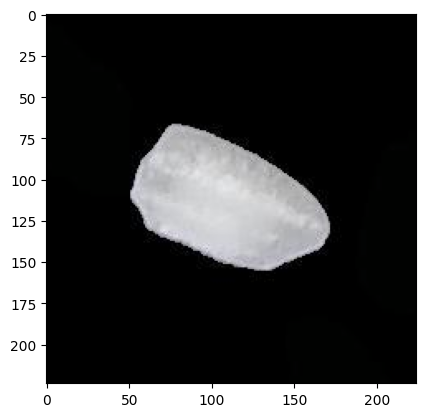

In [21]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    if title is not None:
        ax.set_title(title)
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

image = process_image('Rice_Image_Dataset\Test\Arborio (10029).jpg')
imshow(image)

In [39]:
def predict(image_path, model, topk=1):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    image = process_image(image_path)
    
    # Convert image to PyTorch tensor first
    image = torch.from_numpy(image).type(torch.cuda.FloatTensor)
    #print(image.shape)
    #print(type(image))
    
    # Returns a new tensor with a dimension of size one inserted at the specified position.
    image = image.unsqueeze(0)
    
    output = model.forward(image)
    
    probabilities = torch.exp(output)
    
    # Probabilities and the indices of those probabilities corresponding to the classes
    top_probabilities, top_indices = probabilities.topk(topk)
    
    # Convert to lists
    top_probabilities = top_probabilities.detach().type(torch.FloatTensor).numpy().tolist()[0] 
    top_indices = top_indices.detach().type(torch.FloatTensor).numpy().tolist()[0] 
    
    # Convert topk_indices to the actual class labels using class_to_idx
    # Invert the dictionary so you get a mapping from index to class.
    
    # idx_to_class = {value: key for key, value in model.class_to_idx.items()}
    # print(idx_to_class)
    
    # top_classes = [idx_to_class[index] for index in top_indices]
    
    return top_indices[0]
    
result = predict('Rice_Image_Dataset\Test\Arborio (10003).jpg', model)   
print(result)

0.0
